# importing libraries

In [308]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

# EDA

In [309]:
data = pd.read_table('data/healthcare-dataset-stroke-data.csv',sep=',')

In [310]:
data.head(2)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1


In [311]:
data.shape

(5110, 12)

In [312]:
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [313]:
data.duplicated().unique()

array([False])

Missing Values

In [314]:
data.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [315]:
data = data.fillna(data["bmi"].median())

Pivot tables

In [316]:
def pivot(data,values,index,color):
    pivot_table=pd.pivot_table(data, values=values, 
                             index=index,
                             aggfunc='count')
    pivot_table = pivot_table.style.background_gradient(sns.light_palette(color, as_cmap=True))
    return pivot_table

In [317]:
gender_status= pivot(data,'stroke',['gender', 'ever_married'],'red')
gender_status

In [318]:
data=data[data.gender!='Other']
gender_status= pivot(data,'stroke',['gender', 'ever_married'],'red')
gender_status

In [319]:
gender_tension=pivot(data,'stroke',['gender', 'hypertension'],'green')
gender_tension

In [320]:
gender_work=pivot(data,'stroke',['gender', 'work_type'],'yellow')
gender_work

In [321]:
gender_smoke=pivot(data,'stroke',['gender', 'smoking_status'],'darkblue')
gender_smoke

In [322]:
gender_residence=pivot(data,'stroke',['gender', 'Residence_type'],'purple')
gender_residence

In [323]:
'''
correlation = data.corr()
def heatmap(corr_matrix):
    sns.set(style="dark")
    f, ax = plt.subplots(figsize=(11, 9))
    mask = np.zeros_like(corr_matrix, dtype=bool)
    mask[np.triu_indices_from(mask)] = True 
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(20, 5, as_cmap=True)
    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, ax=ax)
heatmap(correlation)
'''

'\ncorrelation = data.corr()\ndef heatmap(corr_matrix):\n    sns.set(style="dark")\n    f, ax = plt.subplots(figsize=(11, 9))\n    mask = np.zeros_like(corr_matrix, dtype=bool)\n    mask[np.triu_indices_from(mask)] = True \n    # Generate a custom diverging colormap\n    cmap = sns.diverging_palette(20, 5, as_cmap=True)\n    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, ax=ax)\nheatmap(correlation)\n'

# Outliers 

In [324]:
def box_plot(data,x,y):
    f, ax = plt.subplots(figsize=(6.5, 6.5))
    sns.boxplot(x=x, y=y,
                data=data, ax=ax)

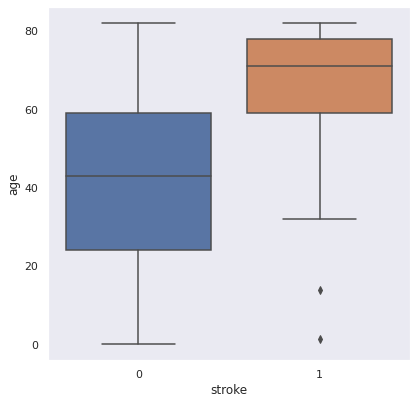

In [325]:
box_plot(data,"stroke","age")

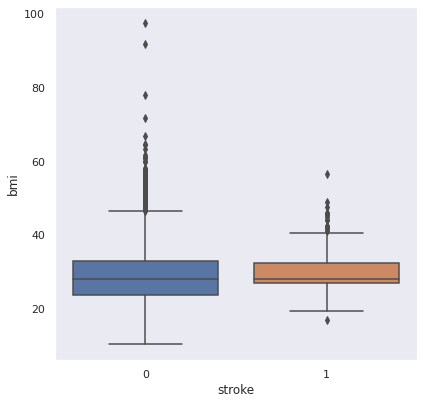

In [326]:
box_plot(data,"stroke","bmi")

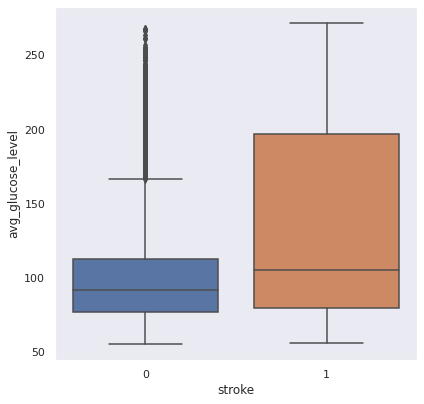

In [327]:
box_plot(data,"stroke","avg_glucose_level")

In [328]:
def iqr(data):
    global outliers
    outliers = []
    Q1 = np.percentile(data, 25, method = 'midpoint')
    Q2 = np.percentile(data, 50, method = 'midpoint')  
    Q3 = np.percentile(data, 75, method = 'midpoint')
    IQR = Q3 - Q1
    low_lim = Q1 - 1.5 * IQR
    up_lim = Q3 + 1.5 * IQR
    for x in data:
        if (x> up_lim):
            data.replace(x,up_lim,inplace=True)
            outliers.append(x)
        elif(x<low_lim):
            data.replace(x,low_lim,inplace=True)
            outliers.append(x)
   
    return data

In [329]:
age_outlier_imputation=iqr(data['age'])
avg_glucose_level_outlier__imputation=iqr(data['avg_glucose_level'])
bmi_outlier_imputation=iqr(data['bmi'])

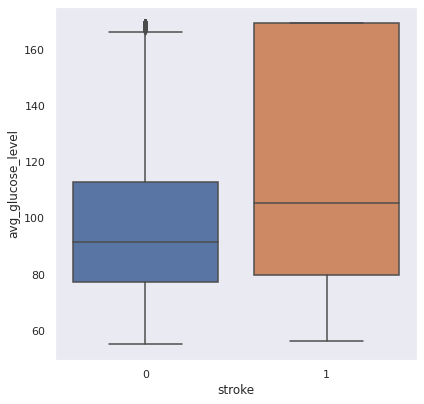

In [330]:
box_plot(data,"stroke","avg_glucose_level")

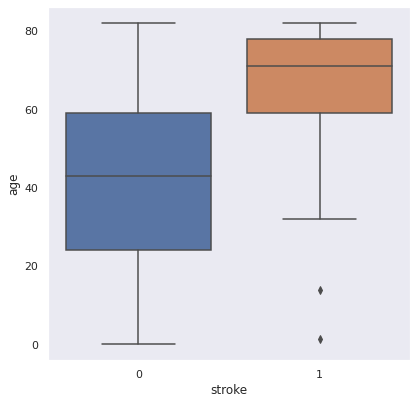

In [331]:
box_plot(data,"stroke","age")

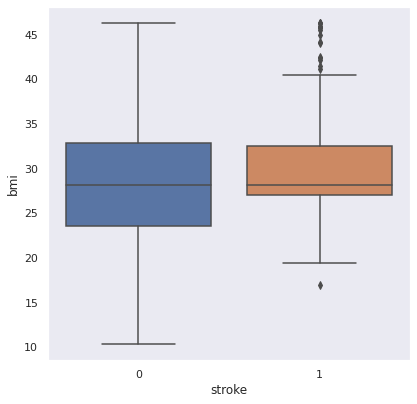

In [332]:
box_plot(data,"stroke","bmi")

In [333]:
X = data.drop('stroke', axis=1)
y = data['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [334]:
numeric_transformer = Pipeline(steps=[
     ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
numeric_features = data.select_dtypes(include=['int64', 'float64']).drop(['stroke'],axis=1).columns
categorical_features = data.select_dtypes(include=['object']).columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [335]:
rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(random_state = 0))])
rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level',
       'bmi'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object'))])),
                ('classifier', RandomForestClassifier(random_state=0))])

In [336]:
y_pred = rf.predict(X_test)

In [345]:
print("Accuracy of the model: ",accuracy_score(y_pred, y_test))
print("Precision of the model: ",precision_score(y_pred, y_test,average='micro'))
print("Recall of the model: ",recall_score(y_pred, y_test,average='micro'))
print("F1_Score of the model: ",f1_score(y_pred, y_test,average='micro'))
print("MSE: ",mean_squared_error(y_pred, y_test))

Accuracy of the model:  0.945226917057903
Precision of the model:  0.945226917057903
Recall of the model:  0.945226917057903
F1_Score of the model:  0.945226917057903
MSE:  0.054773082942097026


In [346]:
random_search = {'classifier__n_estimators':np.arange(5,100,5),
                 'classifier__max_features': ['sqrt', 'log2'],
                 'classifier__criterion' :['gini', 'entropy'],
                 'classifier__max_depth' : [4,5,6,7,8,9,10,11,12]
                 }                           
CV = RandomizedSearchCV(rf, random_search, cv=5, scoring="r2",
                        verbose=1,n_jobs=-1,n_iter=50, random_state = 0)
CV.fit(X_train, y_train) 
print(CV.best_params_)    

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'classifier__n_estimators': 30, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 11, 'classifier__criterion': 'entropy'}


In [347]:
rf2 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(n_estimators= 30,
                                                             max_features= 'sqrt', 
                                                             max_depth= 11, 
                                                             criterion= 'gini',
                                                            verbose=1,n_jobs=-1,
                                                            random_state = 0))])

In [348]:
rf2.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level',
       'bmi'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(max_depth=11, n_estimators=30,
                                        n_jobs=-1, random_state=0,
                                        verbose=1))])

In [349]:
y_pred_best = rf2.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    0.0s finished


In [351]:
print("Accuracy of the model: ",accuracy_score(y_pred_best, y_test))
print("Precision of the model: ",precision_score(y_pred_best, y_test,average='micro'))
print("Recall of the model: ",recall_score(y_pred_best, y_test,average='micro'))
print("F1_Score of the model: ",f1_score(y_pred_best, y_test,average='micro'))
print("MSE: ",mean_squared_error(y_pred_best, y_test))

Accuracy of the model:  0.9444444444444444
Precision of the model:  0.9444444444444444
Recall of the model:  0.9444444444444444
F1_Score of the model:  0.9444444444444444
MSE:  0.05555555555555555


In [344]:
pickle.dump(rf, open('model_random_forest.pkl', 'wb'))